In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from time import time

In [2]:
def bernoulli(p):
    return np.random.rand() < p

In [3]:
def two_sample_z_test(est_p, wins, traffic, alpha=0.05):
    winner_idx = np.argmax(est_p)
    second_idx = sorted([(p, i) for i, p in enumerate(est_p)])[-2][1]
    p1, p2 = est_p[winner_idx], est_p[second_idx]
    x1, x2 = wins[winner_idx], wins[second_idx]
    n1, n2 = traffic[winner_idx], traffic[second_idx]

    p_pooled = (x1 + x2) / (n1 + n2)
    se = np.sqrt(p_pooled * (1 - p_pooled) * (1 / n1 + 1 / n2))
    z = (p1 - p2) / se
    p_val = 2*(1 - norm.cdf(abs(z)))
    
    return p_val < alpha

In [4]:
class Arm(object):
    def __init__(self, idx, a=1, b=1):
        self.idx = idx
        self.a = a
        self.b = b
        
    def record_success(self):
        self.a += 1
        
    def record_failure(self):
        self.b += 1
        
    def draw_ctr(self):
        return np.random.beta(self.a, self.b, 1)[0]
    
    def mean(self):
        return self.a / (self.a + self.b)
    
    def __str__(self):
        return "arm %i, a=%i, b=%i"%(self.idx, self.a, self.b)

In [5]:
def k_arm_bandit(ctrs, alpha=0.05, silent=False):
    cols = ["arm_%i_ctr=%.2f"%(i + 1, ctr) for i, ctr in enumerate(ctrs)]
    
    # slow
    # df_history = pd.DataFrame(columns=cols)

    n_arms = len(ctrs)
    arms = [Arm(idx=i) for i in range(n_arms)]
    history = [[] for _ in range(n_arms)]
    
    for i in range(100000):
        sample_p = [arm.draw_ctr() for arm in arms]

        idx = np.argmax(sample_p)
        ctr = ctrs[idx]
        arm = arms[idx]
        
        if bernoulli(ctr):
            arm.record_success()
        else:
            arm.record_failure()

        mean_ps = [arm.mean() for arm in arms]
        wins = [arm.a - 1 for arm in arms]
        traffic = [arm.a + arm.b - 2 for arm in arms]
        
        for j, p in enumerate(mean_ps):
            history[j].append(p)
                
        # slow
        # df_history = df_history.append({col : mean_p for col, mean_p in zip(cols, mean_ps)}, ignore_index=True)
        
        if i > 100:
            if two_sample_z_test(mean_ps, wins, traffic, alpha):
                if not silent: print("Winning arm %i beats second arm at iteration %i"%(idx, i + 1))
                break
    return idx, mean_ps, traffic, history

### A Single Trial

In [19]:
np.random.normal(0.2, 0.1, 5)

array([0.22063634, 0.24316791, 0.19765516, 0.27148533, 0.20855307])

Winning arm 42 beats second arm at iteration 33262


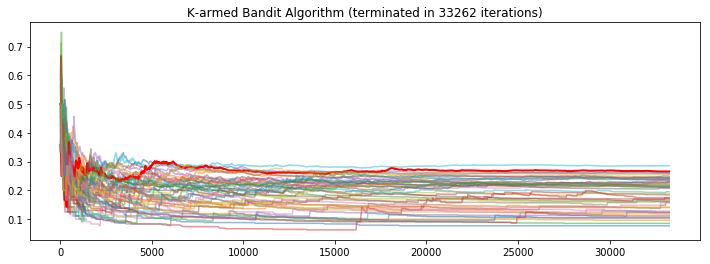

In [50]:
ctrs = [0.18, 0.20, 0.22, 0.24, 0.22, 0.21, 0.23, 0.20, 0.17, 0.21, 0.2]
ctrs = np.random.normal(0.2, 0.05, 50)
alpha = 0.05
winner_idx, est_ps, traffic, history = k_arm_bandit(ctrs)

cols = ["arm_%i_ctr=%.2f"%(i + 1, ctr) for i, ctr in enumerate(ctrs)]
data = {col : hist for col, hist in zip(cols, history)}
df_history = pd.DataFrame(data)

df_history_ma = df_history.rolling(20).mean()

plt.figure(figsize=(12, 4))
for i, col in enumerate(cols):
    if i == winner_idx:
        plt.plot(df_history_ma[col], lw=2, color='r')
    else:
        plt.plot(df_history_ma[col], alpha=0.5)
    
# plt.legend(["true ctr = %.2f, est ctr = %.2f"%(true, est) for true, est in zip(ctrs, est_ps)],
#           loc='center left', bbox_to_anchor=(1, 0.5))

plt.title("K-armed Bandit Algorithm (terminated in %i iterations)"%sum(traffic))

plt.savefig('outputs/bandit.png')
plt.show()

### True Positive Rate

In [ ]:
start = time()

ctrs = [0.1, 0.2, 0.15]
true_winner_idx = np.argmax(ctrs)
n_trials = 10000
success = 0
iters = []

for i in range(n_trials):
    winner_idx, _, traffic, _ = k_arm_bandit(ctrs=ctrs, alpha=0.02, silent=True)
    iters.append(sum(traffic))
    if winner_idx == true_winner_idx:
        success += 1
    if i % 10 == 0:
        print("Progress %.2f%%..."%(100 * i / n_trials), end="\r")
print("probability of finding winner: %.2f%%"%(100 * success / n_trials))

end = time()
print("time elapsed: %.2fs"%(end - start))

In [ ]:
print("average iteration %.2f, std %.2f"%(np.mean(iters), np.std(iters)))

plt.hist(iters)
plt.show()